# Fake News Detection 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
data.head()

,title,text,subject,date,target
0,WATCH: UNHINGED CLINTON SUPPORTER Knocks Elder...,"Hillary s lawless, anti-American supporters we...",politics,"Aug 1, 2016",fake
1,Trump Jr. tweet likening Syrian refugees to po...,NEW YORK (Reuters) - The maker of Skittles can...,politicsNews,"September 20, 2016",true
2,"Wikipedia BRUTALLY Trashes Paul Ryan, Adds Hi...",Donald Trump s latest executive orders are bei...,News,"January 28, 2017",fake
3,Another Fox Host Just Got Busted Sexually Har...,It s an epidemic over there inside the Fox net...,News,"August 4, 2017",fake
4,Britain says Iran's treatment of jailed aid wo...,LONDON (Reuters) - Iran s continued detention ...,worldnews,"November 7, 2017",true


In [9]:
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,WATCH: UNHINGED CLINTON SUPPORTER Knocks Elder...,"Hillary s lawless, anti-American supporters we...",politics,fake
1,Trump Jr. tweet likening Syrian refugees to po...,NEW YORK (Reuters) - The maker of Skittles can...,politicsNews,true
2,"Wikipedia BRUTALLY Trashes Paul Ryan, Adds Hi...",Donald Trump s latest executive orders are bei...,News,fake
3,Another Fox Host Just Got Busted Sexually Har...,It s an epidemic over there inside the Fox net...,News,fake
4,Britain says Iran's treatment of jailed aid wo...,LONDON (Reuters) - Iran s continued detention ...,worldnews,true


In [10]:
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,"Hillary s lawless, anti-American supporters we...",politics,fake
1,NEW YORK (Reuters) - The maker of Skittles can...,politicsNews,true
2,Donald Trump s latest executive orders are bei...,News,fake
3,It s an epidemic over there inside the Fox net...,News,fake
4,LONDON (Reuters) - Iran s continued detention ...,worldnews,true


In [11]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,"hillary s lawless, anti-american supporters we...",politics,fake
1,new york (reuters) - the maker of skittles can...,politicsNews,true
2,donald trump s latest executive orders are bei...,News,fake
3,it s an epidemic over there inside the fox net...,News,fake
4,london (reuters) - iran s continued detention ...,worldnews,true


In [12]:
import string
def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,hillary s lawless antiamerican supporters were...,politics,fake
1,new york reuters the maker of skittles candie...,politicsNews,true
2,donald trump s latest executive orders are bei...,News,fake
3,it s an epidemic over there inside the fox net...,News,fake
4,london reuters iran s continued detention of ...,worldnews,true


In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\AKSHAYA
[nltk_data]     SHREE\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [15]:
data.head()

,text,subject,target
0,hillary lawless antiamerican supporters clearl...,politics,fake
1,new york reuters maker skittles candies tuesda...,politicsNews,true
2,donald trump latest executive orders protested...,News,fake
3,epidemic inside fox network studios guys seem ...,News,fake
4,london reuters iran continued detention jailed...,worldnews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


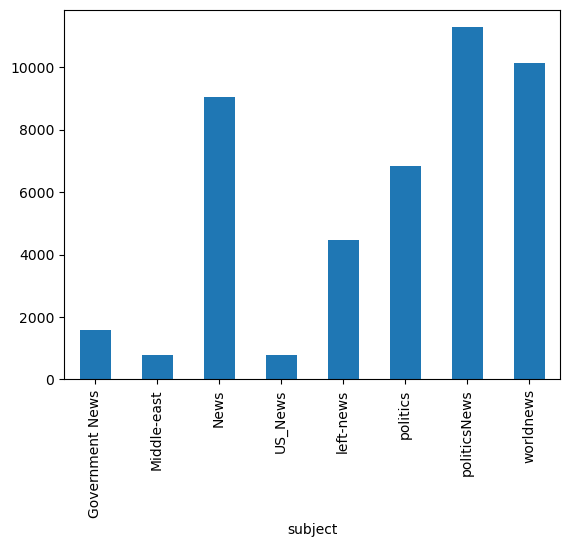

In [16]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


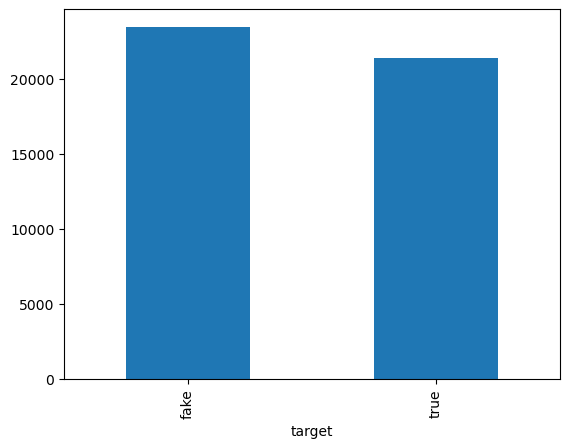

In [17]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

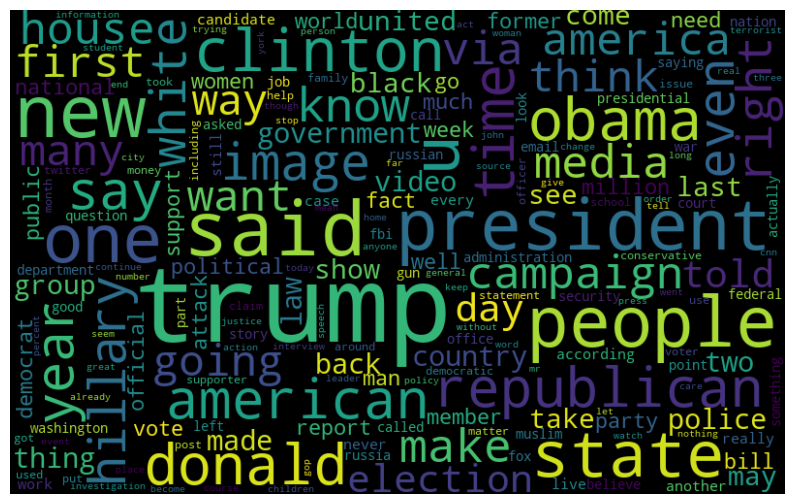

In [20]:
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

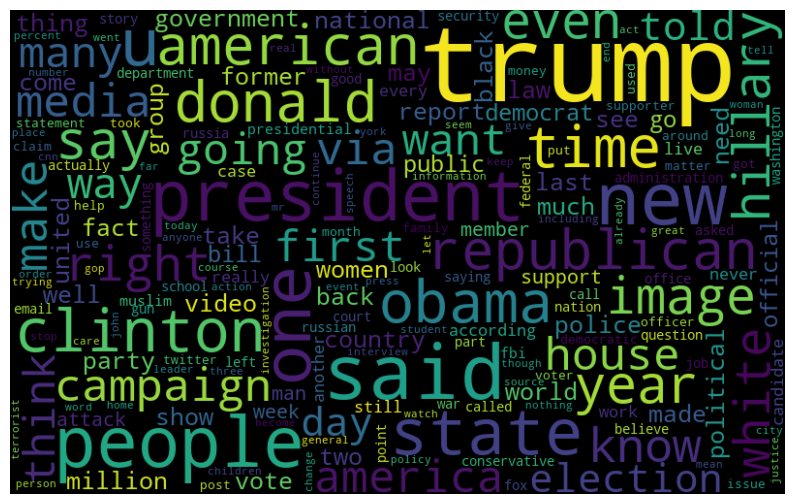

In [21]:
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

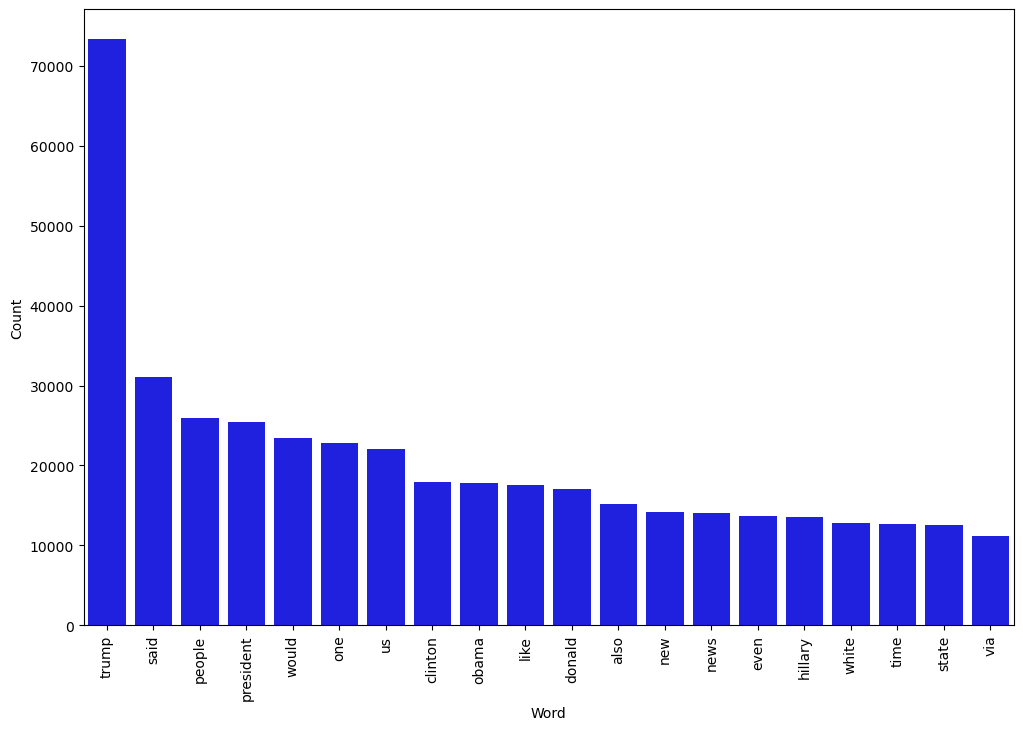

In [23]:
counter(data[data["target"] == "fake"], "text", 20)

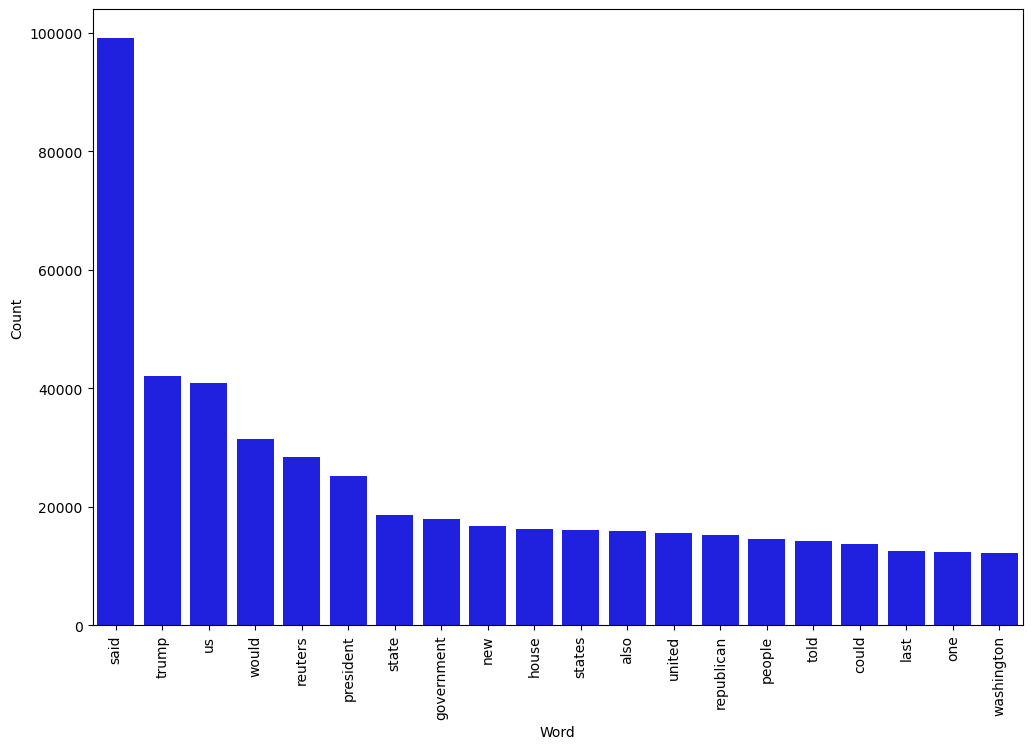

In [24]:
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [25]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [26]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# **Naive Bayes**




In [27]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.36%


Confusion matrix, without normalization


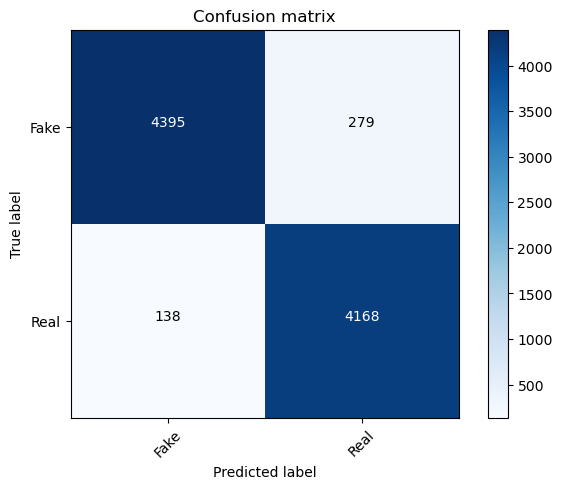

In [28]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [29]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.03%


Confusion matrix, without normalization


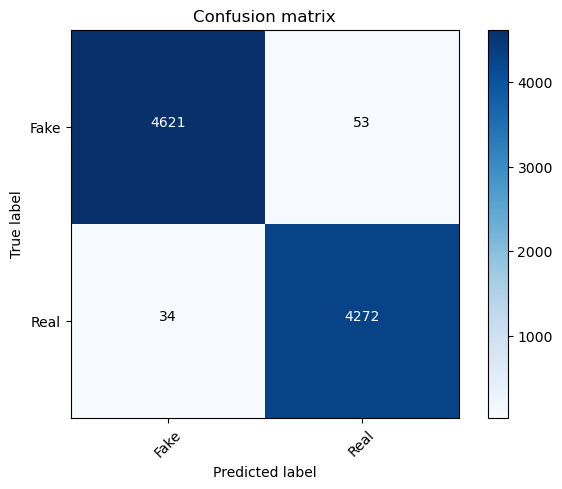

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [31]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.69%


Confusion matrix, without normalization


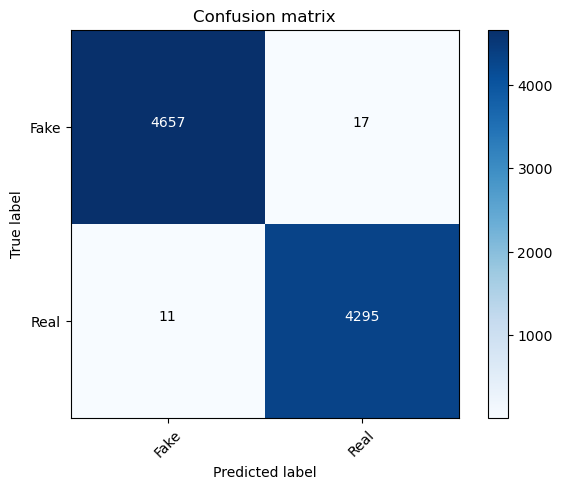

In [32]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [33]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 98.85%


Confusion matrix, without normalization


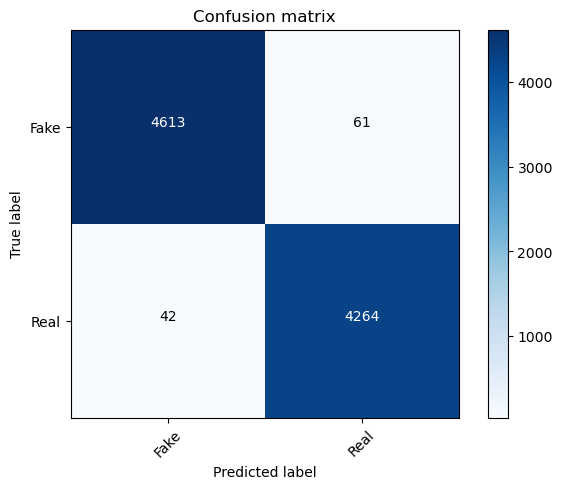

In [34]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x29102092650>,
 [Text(0, 91, '91'),
  Text(0, 92, '92'),
  Text(0, 93, '93'),
  Text(0, 94, '94'),
  Text(0, 95, '95'),
  Text(0, 96, '96'),
  Text(0, 97, '97'),
  Text(0, 98, '98'),
  Text(0, 99, '99'),
  Text(0, 100, '100')])

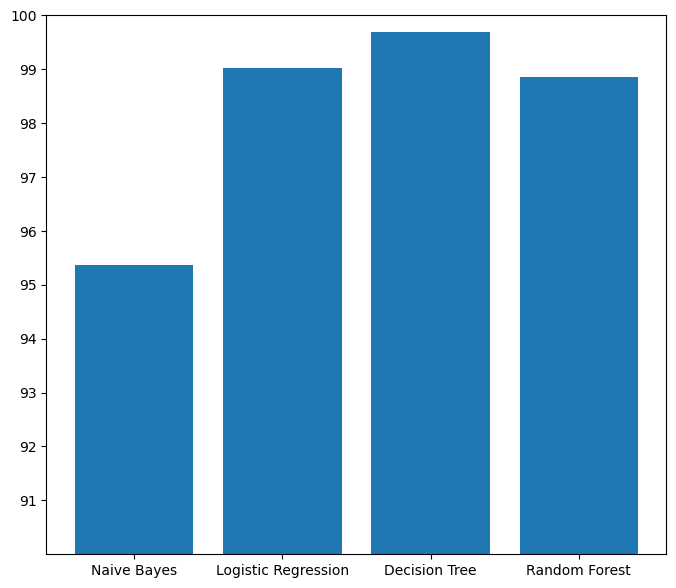

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))